# Prediciendo la diabetes
## El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

# 1.0 Importamos las librerias a utilizar

In [34]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import joblib
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

 # 1.1 Importamos los datos

In [36]:
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/diabetes.csv')
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:
df.shape

(768, 9)

# 2.1 Identificamos columnas con valores unicos

In [38]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
763
764
765
766


# 2.2 Eliminamos filas y columnas duplicadas

In [39]:
# Comporbar ducpliados
df.duplicated().sum()

np.int64(0)

In [40]:
df.T.duplicated().sum()

np.int64(0)

# 2.3 Identificamos columnas redundantes

Tras realizar un análisis superficial del dataset, no se identificaron columnas redundantes evidentes. Cada una de las 9 columnas representa una medida diagnóstica diferente y cumple un propósito específico en la predicción de diabetes.

# 2.4 Eliminar columnas Data leakage

En este dataset no se identificaron columnas que generen data leakage. Todas las variables predictoras representan medidas diagnósticas que se pueden obtener antes de conocer el resultado del diagnóstico de diabetes.

# 2.5 Buscamos valores faltantes

In [41]:
df.shape

(768, 9)

In [42]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

Series([], dtype: float64)

# 2.5.1 Busqueda profunda de valores faltantes

In [43]:
# Buscar valores 0 en columnas específicas
columnas_a_revisar = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

print("Análisis de valores 0 en columnas clave:")
print("="*60)

for columna in columnas_a_revisar:
    count_zeros = (df[columna] == 0).sum()
    porcentaje = (count_zeros / len(df)) * 100
    print(f"{columna:20s}: {count_zeros:4d} filas con 0 ({porcentaje:.2f}%)")

print("="*60)
print(f"Total de filas en el dataset: {len(df)}")

# Reemplazar valores 0 por NaN para su posterior tratamiento
print("\n" + "="*60)
print("Reemplazando valores 0 por NaN en columnas relevantes...")
print("="*60)

for columna in columnas_a_revisar:
    df[columna] = df[columna].replace(0, np.nan)
    
print("✅ Valores 0 reemplazados por NaN exitosamente")
print(f"\nNuevos valores faltantes por columna:")
faltantes_nuevos = df[columnas_a_revisar].isna().sum()
for columna, cantidad in faltantes_nuevos.items():
    porcentaje = (cantidad / len(df)) * 100
    print(f"{columna:20s}: {cantidad:4d} NaN ({porcentaje:.2f}%)")

Análisis de valores 0 en columnas clave:
Glucose             :    5 filas con 0 (0.65%)
BloodPressure       :   35 filas con 0 (4.56%)
SkinThickness       :  227 filas con 0 (29.56%)
Insulin             :  374 filas con 0 (48.70%)
BMI                 :   11 filas con 0 (1.43%)
Age                 :    0 filas con 0 (0.00%)
Total de filas en el dataset: 768

Reemplazando valores 0 por NaN en columnas relevantes...
✅ Valores 0 reemplazados por NaN exitosamente

Nuevos valores faltantes por columna:
Glucose             :    5 NaN (0.65%)
BloodPressure       :   35 NaN (4.56%)
SkinThickness       :  227 NaN (29.56%)
Insulin             :  374 NaN (48.70%)
BMI                 :   11 NaN (1.43%)
Age                 :    0 NaN (0.00%)


<Axes: >

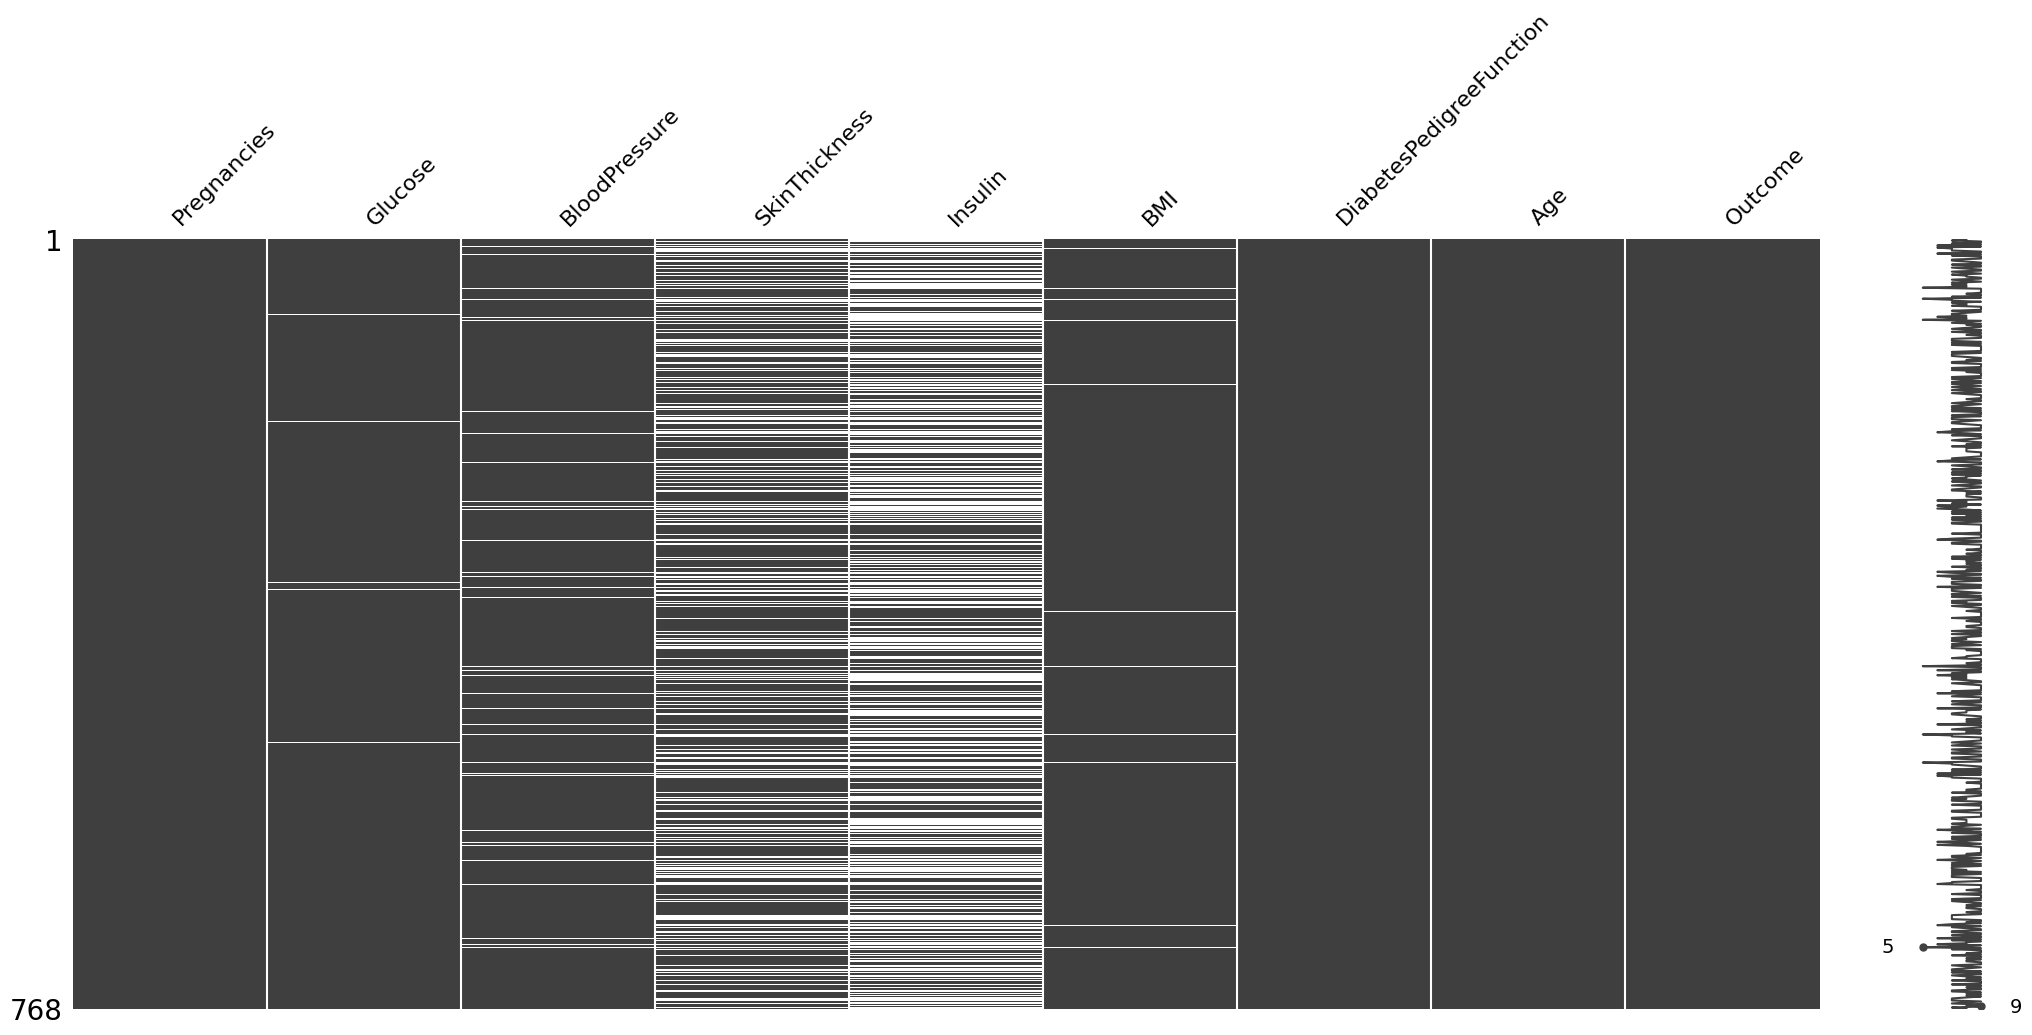

In [44]:
msno.matrix(df)

In [45]:
df.shape

(768, 9)

# 2.6 Identificación de valores faltantes

**Estrategia:** En lugar de eliminar columnas importantes como Insulin y SkinThickness, utilizaremos **IterativeImputer** que:
- Usa modelos de regresión para predecir valores faltantes
- Aprovecha las correlaciones entre variables
- Mantiene toda la información predictora disponible

**⚠️ NOTA IMPORTANTE:** La imputación se realizará DESPUÉS del train-test split (sección 3.2) para evitar **data leakage**.

Esto es crucial porque variables como Insulin y SkinThickness son importantes para predecir diabetes, a pesar de tener valores faltantes.

In [46]:
# Verificar los valores faltantes antes del split
print("Valores faltantes por columna:")
print(df.isna().sum())
print(f"\nTotal de valores faltantes: {df.isna().sum().sum()}")
print(f"📊 Forma del dataframe: {df.shape}")

Valores faltantes por columna:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Total de valores faltantes: 652
📊 Forma del dataframe: (768, 9)


# 2.7 Guardar dataframe limpio para reutilización

Se guarda el dataframe con los valores 0 reemplazados por NaN (pero sin imputar) para que otros ejercicios puedan aplicar sus propias estrategias de imputación sin data leakage.

In [47]:
# Guardar el dataframe limpio (con NaN, sin imputar) para uso en otros ejercicios
os.makedirs('/workspaces/carlos060495-intro-ml/data/processed', exist_ok=True)
df.to_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')

print("✅ Dataframe guardado exitosamente en:")
print("   📁 data/processed/diabetes_clean.pkl")
print(f"\n📊 Forma del dataframe: {df.shape}")
print(f"📋 Columnas: {list(df.columns)}")
print(f"⚠️  Valores faltantes: {df.isna().sum().sum()} (listos para imputar según necesidad)")

✅ Dataframe guardado exitosamente en:
   📁 data/processed/diabetes_clean.pkl

📊 Forma del dataframe: (768, 9)
📋 Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
⚠️  Valores faltantes: 652 (listos para imputar según necesidad)


# 3.1 Train test split

In [48]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3.2 Imputación de valores faltantes

In [50]:
# Crear el imputador iterativo
imputer = IterativeImputer(random_state=42, max_iter=10, verbose=0)

print("Valores faltantes ANTES de la imputación:")
print(f"X_train: {X_train.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test.isna().sum().sum()} valores faltantes")

# PASO 1: Entrenar el imputador SOLO con los datos de entrenamiento
imputer.fit(X_train)

# PASO 2: Transformar ambos conjuntos usando el imputador entrenado
X_train_imputed = pd.DataFrame(
    imputer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\n" + "="*60)
print("Valores faltantes DESPUÉS de la imputación:")
print(f"X_train: {X_train_imputed.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test_imputed.isna().sum().sum()} valores faltantes")

# Verificar valores negativos y corregirlos si existen
for col in X_train_imputed.columns:
    if (X_train_imputed[col] < 0).any():
        print(f"⚠️  Corrigiendo valores negativos en {col}")
        median_val = X_train_imputed[X_train_imputed[col] >= 0][col].median()
        X_train_imputed.loc[X_train_imputed[col] < 0, col] = median_val
        X_test_imputed.loc[X_test_imputed[col] < 0, col] = median_val

print("\n✅ Imputación completada correctamente SIN data leakage")
print(f"📊 X_train shape: {X_train_imputed.shape}")
print(f"📊 X_test shape: {X_test_imputed.shape}")

# Actualizar los conjuntos de datos
X_train = X_train_imputed
X_test = X_test_imputed

Valores faltantes ANTES de la imputación:
X_train: 502 valores faltantes
X_test: 150 valores faltantes

Valores faltantes DESPUÉS de la imputación:
X_train: 0 valores faltantes
X_test: 0 valores faltantes
⚠️  Corrigiendo valores negativos en Insulin

✅ Imputación completada correctamente SIN data leakage
📊 X_train shape: (614, 8)
📊 X_test shape: (154, 8)


# 4.1 Arbol de desicion simple

In [51]:
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, random_state=42)
simple_tree.fit(X_train, y_train)

complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)

# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [52]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

# 3.2 Imputación de valores faltantes (DESPUÉS del split)

**⚠️ IMPORTANTE:** La imputación se realiza DESPUÉS del train-test split para evitar **data leakage**.

- El IterativeImputer se **entrena solo con X_train**
- Se **transforma tanto X_train como X_test** usando el mismo imputador
- Esto garantiza que no se filtre información del conjunto de prueba al entrenamiento

In [53]:
# Crear el imputador iterativo
imputer = IterativeImputer(random_state=42, max_iter=10, verbose=0)

print("Valores faltantes ANTES de la imputación:")
print(f"X_train: {X_train.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test.isna().sum().sum()} valores faltantes")

# PASO 1: Entrenar el imputador SOLO con los datos de entrenamiento
imputer.fit(X_train)

# PASO 2: Transformar ambos conjuntos usando el imputador entrenado
X_train_imputed = pd.DataFrame(
    imputer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\n" + "="*60)
print("Valores faltantes DESPUÉS de la imputación:")
print(f"X_train: {X_train_imputed.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test_imputed.isna().sum().sum()} valores faltantes")

# Verificar valores negativos y corregirlos si existen
for col in X_train_imputed.columns:
    if (X_train_imputed[col] < 0).any():
        print(f"⚠️  Corrigiendo valores negativos en {col}")
        median_val = X_train_imputed[X_train_imputed[col] >= 0][col].median()
        X_train_imputed.loc[X_train_imputed[col] < 0, col] = median_val
        X_test_imputed.loc[X_test_imputed[col] < 0, col] = median_val

print("\n✅ Imputación completada correctamente SIN data leakage")
print(f"📊 X_train shape: {X_train_imputed.shape}")
print(f"📊 X_test shape: {X_test_imputed.shape}")

# Actualizar los conjuntos de datos
X_train = X_train_imputed
X_test = X_test_imputed

Valores faltantes ANTES de la imputación:
X_train: 0 valores faltantes
X_test: 0 valores faltantes

Valores faltantes DESPUÉS de la imputación:
X_train: 0 valores faltantes
X_test: 0 valores faltantes

✅ Imputación completada correctamente SIN data leakage
📊 X_train shape: (614, 8)
📊 X_test shape: (154, 8)

Valores faltantes DESPUÉS de la imputación:
X_train: 0 valores faltantes
X_test: 0 valores faltantes

✅ Imputación completada correctamente SIN data leakage
📊 X_train shape: (614, 8)
📊 X_test shape: (154, 8)


In [54]:
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.742671,0.496815,0.654420,0.772277,0.366197,0.942643
Test,0.727273,0.461538,0.638384,0.782609,0.327273,0.949495
Diferencia,0.015398,0.035277,0.016036,-0.010331,0.038924,-0.006852


In [55]:
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.681818,0.566372,0.659596,0.551724,0.581818,0.737374
Diferencia,0.318182,0.433628,0.340404,0.448276,0.418182,0.262626


In [56]:
# Matriz de confusión
cm = confusion_matrix(y_test, test_pred_simple)
cm

array([[94,  5],
       [37, 18]])

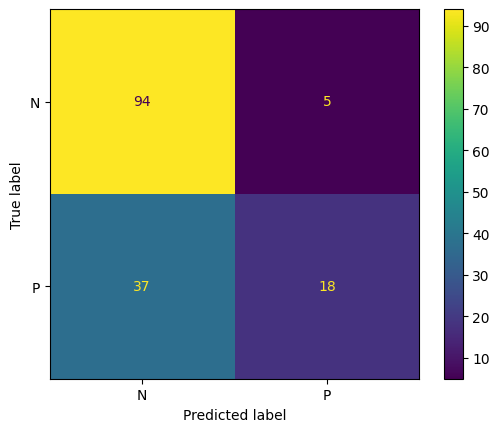

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'P'])
disp.plot()

In [58]:
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Insulin <= 120.22
|   |--- Glucose <= 127.00
|   |   |--- SkinThickness <= 23.68
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  23.68
|   |   |   |--- class: 0
|   |--- Glucose >  127.00
|   |   |--- class: 1
|--- Insulin >  120.22
|   |--- Age <= 24.50
|   |   |--- BMI <= 31.10
|   |   |   |--- class: 0
|   |   |--- BMI >  31.10
|   |   |   |--- class: 0
|   |--- Age >  24.50
|   |   |--- Glucose <= 154.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  154.50
|   |   |   |--- class: 1



# 4.2 Comparación de criterios de pureza

In [59]:
# Definir los criterios a probar
criterios = ['gini', 'entropy', 'log_loss']

# Diccionario para almacenar los modelos y resultados
resultados = {}

# Entrenar un modelo con cada criterio
for criterio in criterios:
    # Crear el modelo
    modelo = DecisionTreeClassifier(
        criterion=criterio,
        max_depth=5,
        min_samples_leaf=15,
        random_state=42
    )
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Guardar resultados
    resultados[criterio] = {
        'modelo': modelo,
        'train_pred': y_pred_train,
        'test_pred': y_pred_test,
        'metrics': get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    }
    
print("Modelos entrenados exitosamente para todos los criterios.")

Modelos entrenados exitosamente para todos los criterios.


In [60]:
# Mostrar las métricas de cada criterio
for criterio in criterios:
    print(f"\n{'='*60}")
    print(f"CRITERIO: {criterio.upper()}")
    print(f"{'='*60}")
    print(resultados[criterio]['metrics'])


CRITERIO: GINI
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.815961  0.730310  0.793070   0.742718  0.718310     0.867830
Test        0.733766  0.643478  0.720202   0.616667  0.672727     0.767677
Diferencia  0.082195  0.086832  0.072868   0.126052  0.045583     0.100154

CRITERIO: ENTROPY
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.825733  0.759551  0.818160   0.728448  0.793427     0.842893
Test        0.759740  0.683761  0.752525   0.645161  0.727273     0.777778
Diferencia  0.065993  0.075790  0.065635   0.083287  0.066155     0.065115

CRITERIO: LOG_LOSS
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.825733  0.759551  0.818160   0.728448  0.793427     0.842893
Test        0.759740  0.683761  0.752525   0.645161  0.727273     0.777778
Diferencia  0.065993  0.075790  0.065635   0.083287  0.066155     0.065115


In [61]:
# Crear DataFrame comparativo con métricas de test
comparacion_test = pd.DataFrame({
    'Gini': resultados['gini']['metrics'].loc['Test'],
    'Entropy': resultados['entropy']['metrics'].loc['Test'],
    'Log_Loss': resultados['log_loss']['metrics'].loc['Test']
}).T

print("Comparación de métricas en conjunto de TEST:")
print(comparacion_test)

Comparación de métricas en conjunto de TEST:
          Accuracy        F1       AUC  Precision    Recall  Specificity
Gini      0.733766  0.643478  0.720202   0.616667  0.672727     0.767677
Entropy   0.759740  0.683761  0.752525   0.645161  0.727273     0.777778
Log_Loss  0.759740  0.683761  0.752525   0.645161  0.727273     0.777778


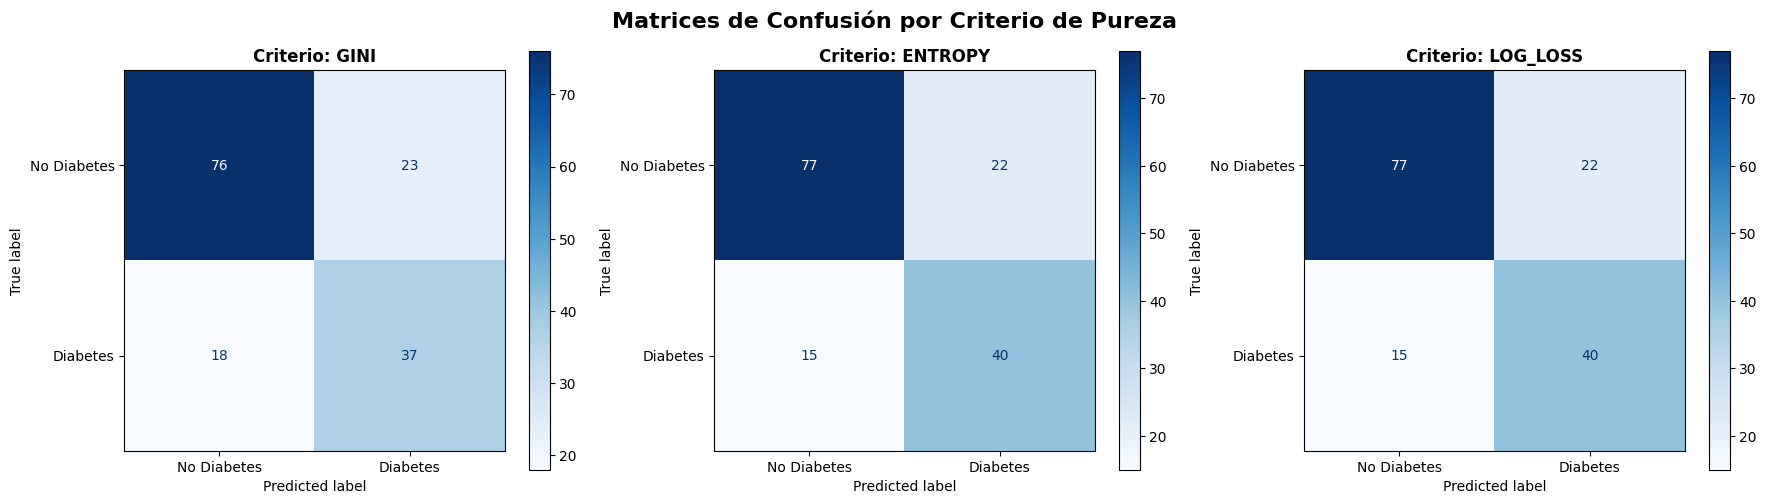

In [62]:
# Comparar matrices de confusión de los tres criterios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusión por Criterio de Pureza', fontsize=16, fontweight='bold')

for idx, criterio in enumerate(criterios):
    cm = confusion_matrix(y_test, resultados[criterio]['test_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'Criterio: {criterio.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Selección del mejor criterio
Después de analizar los resultados de los tres criterios de pureza, observamos que **Entropy y Log_Loss produjeron métricas idénticas** y superiores a Gini

Hemos seleccionado el criterio **Entropy** para nuestro modelo final de predicción de diabetes.

# 5.1 Hiperparametros

In [63]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de hiperparámetros para DecisionTreeClassifier
# Ya seleccionamos 'entropy' como mejor criterio, así que lo fijamos
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear el modelo base con criterion='entropy'
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1',  # Usamos F1 por el balance entre precision y recall
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ajustar el modelo
print("Iniciando búsqueda de hiperparámetros con criterion='entropy'...")
grid_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("\n" + "="*60)
print("Mejores hiperparámetros encontrados:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1 Score en validación cruzada: {grid_search.best_score_:.4f}")

# Guardar el mejor modelo
best_model = grid_search.best_estimator_

Iniciando búsqueda de hiperparámetros con criterion='entropy'...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, mi

In [64]:
# Evaluar el mejor modelo
y_pred_train_best = best_model.predict(X_train)
y_pred_test_best = best_model.predict(X_test)

# Obtener métricas del mejor modelo
best_metrics = get_metrics(y_train, y_test, y_pred_train_best, y_pred_test_best)

print("\n" + "="*60)
print("Métricas del modelo optimizado:")
print("="*60)
print(best_metrics)


Métricas del modelo optimizado:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.773616  0.687640  0.760651   0.659483  0.718310     0.802993
Test        0.701299  0.616667  0.694949   0.569231  0.672727     0.717172
Diferencia  0.072317  0.070974  0.065702   0.090252  0.045583     0.085821


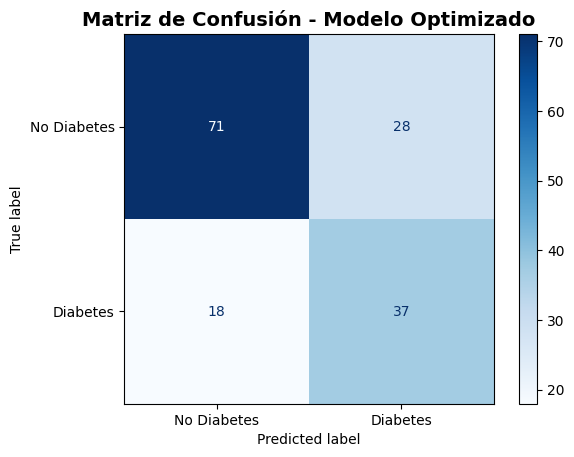

In [65]:
# Matriz de confusión del modelo optimizado
cm_best = confusion_matrix(y_test, y_pred_test_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Diabetes', 'Diabetes'])
disp_best.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Modelo Optimizado', fontsize=14, fontweight='bold')
plt.show()

In [66]:


# Crear directorio para modelos si no existe
model_dir = '/workspaces/carlos060495-intro-ml/models'
os.makedirs(model_dir, exist_ok=True)

# Guardar el modelo optimizado
model_path = os.path.join(model_dir, 'decision_tree_diabetes.pkl')
joblib.dump(best_model, model_path)

print(f"✅ Modelo guardado exitosamente en: {model_path}")
print(f"📊 Tamaño del archivo: {os.path.getsize(model_path) / 1024:.2f} KB")

✅ Modelo guardado exitosamente en: /workspaces/carlos060495-intro-ml/models/decision_tree_diabetes.pkl
📊 Tamaño del archivo: 2.65 KB
